# **Import**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# **Load the Dataset**

In [5]:
# Load the Dataset
file_path = "/content/drive/MyDrive/Projects/laptopPrice.csv"
data = pd.read_csv(file_path)

# Display the first few rows to check for issues
print(data.head())

# Check for missing values
print("Missing values in each column:\n", data.isnull().sum())

# Basic info
print(data.info())

# Descriptive statistics
print(data.describe())

    brand processor_brand processor_name processor_gnrtn ram_gb ram_type  \
0    ASUS           Intel        Core i3            10th   4 GB     DDR4   
1  Lenovo           Intel        Core i3            10th   4 GB     DDR4   
2  Lenovo           Intel        Core i3            10th   4 GB     DDR4   
3    ASUS           Intel        Core i5            10th   8 GB     DDR4   
4    ASUS           Intel   Celeron Dual   Not Available   4 GB     DDR4   

      ssd      hdd       os  os_bit graphic_card_gb  weight     warranty  \
0    0 GB  1024 GB  Windows  64-bit            0 GB  Casual  No warranty   
1    0 GB  1024 GB  Windows  64-bit            0 GB  Casual  No warranty   
2    0 GB  1024 GB  Windows  64-bit            0 GB  Casual  No warranty   
3  512 GB     0 GB  Windows  32-bit            2 GB  Casual  No warranty   
4    0 GB   512 GB  Windows  64-bit            0 GB  Casual  No warranty   

  Touchscreen msoffice  Price rating_stars  Number of Ratings  \
0          No       N

**Define a function to clean and convert object columns**

In [6]:
def clean_convert_columns(df):
    # Remove 'GB' and 'th' strings and convert to numeric
    df['ram_gb'] = df['ram_gb'].str.replace(' GB', '').astype(int)
    df['ssd'] = df['ssd'].str.replace(' GB', '').astype(int)
    df['hdd'] = df['hdd'].str.replace(' GB', '').astype(int)
    df['os_bit'] = df['os_bit'].str.replace('-bit', '').astype(int)
    df['graphic_card_gb'] = df['graphic_card_gb'].str.replace(' GB', '').astype(int)

    # Handle non-numeric weight values
    df['weight'] = df['weight'].str.replace(' kg', '')
    df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

    # Convert processor generation to numeric, handle 'Not Available'
    df['processor_gnrtn'] = df['processor_gnrtn'].str.replace('th', '').replace('Not Available', np.nan).astype(float)

    # Convert warranty to categorical
    df['warranty'] = LabelEncoder().fit_transform(df['warranty'])

    # Convert rating_stars to numeric
    df['rating_stars'] = pd.to_numeric(df['rating_stars'], errors='coerce')

    return df

data = clean_convert_columns(data)


**Encoding categorical features**

In [7]:
le = LabelEncoder()
data['brand'] = le.fit_transform(data['brand'])
data['processor_brand'] = le.fit_transform(data['processor_brand'])
data['processor_name'] = le.fit_transform(data['processor_name'])
data['ram_type'] = le.fit_transform(data['ram_type'])
data['os'] = le.fit_transform(data['os'])
data['Touchscreen'] = le.fit_transform(data['Touchscreen'])
data['msoffice'] = le.fit_transform(data['msoffice'])

# **Preprocessing**

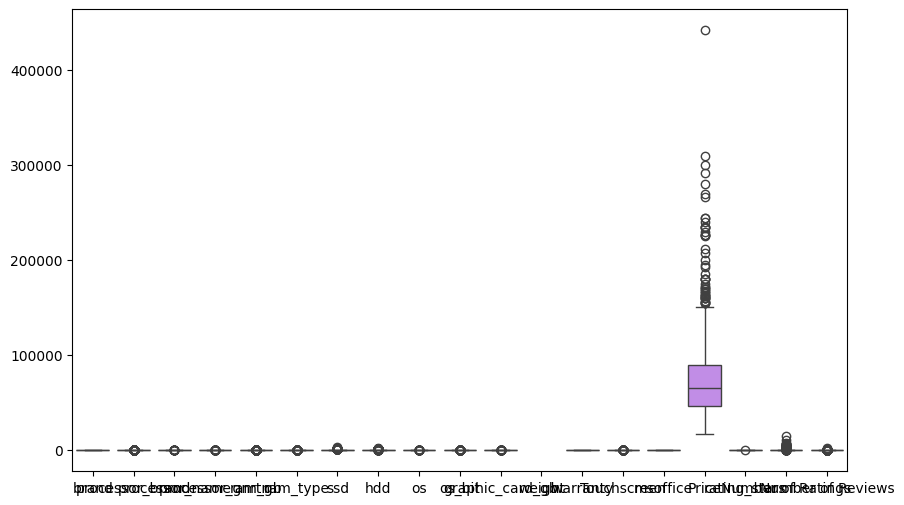

<ipython-input-8-6420e5181812>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
<ipython-input-8-6420e5181812>:22: SettingWithCopyWarning: 
A value is try

In [8]:
# Handling missing values
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Visualizing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[numeric_cols])
plt.show()

# Handling outliers (example: removing data points outside 1.5*IQR)
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_condition = ((data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
data = data.loc[~outliers_condition]

# Rechecking for missing values after outlier removal
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Scaling numeric features
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Features and target variable
X = data.drop(columns=['Price'])
y = data['Price']

# **Split data**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 **XGBoost Regressor and Hyperparameter tuning**

In [10]:
# Model: XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

random_search_xgb = RandomizedSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='neg_mean_absolute_error', n_iter=50, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

# Best parameters for XGBoost
print(f'Best parameters for XGBoost: {random_search_xgb.best_params_}')

# Evaluate the best model
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

print(f'XGBoost MAE: {mean_absolute_error(y_test, y_pred_xgb)}')
print(f'XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb))}')

# Cross-validation for XGBoost
cv_scores = cross_val_score(best_xgb_model, X, y, scoring='neg_mean_absolute_error', cv=5)
print(f'XGBoost Cross-Validation MAE: {-cv_scores.mean()}')

# Feature importance
importances = best_xgb_model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

Best parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
XGBoost MAE: 0.3869980480946366
XGBoost RMSE: 0.7018200722459883
XGBoost Cross-Validation MAE: 0.5865318708808263


# **PLotting**

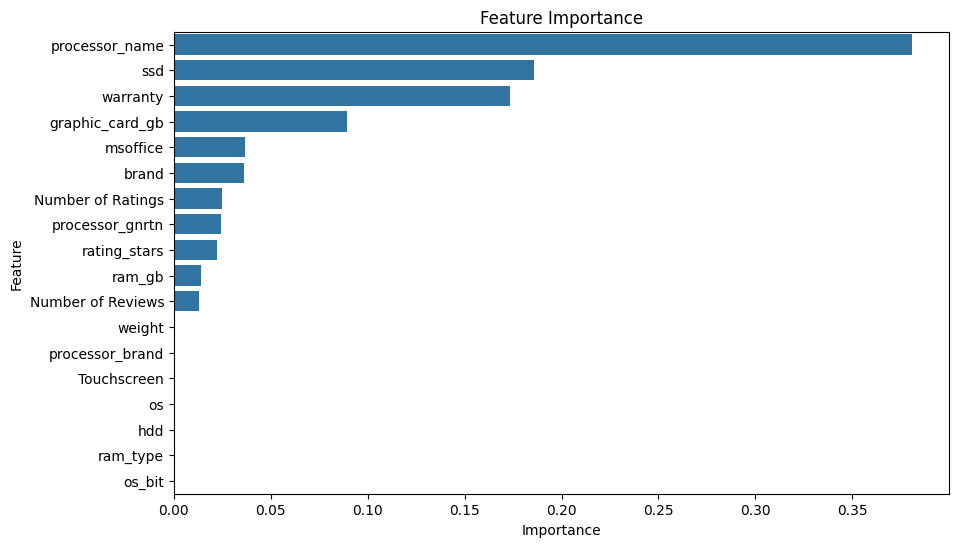

XGBoost MAPE: 141.41%


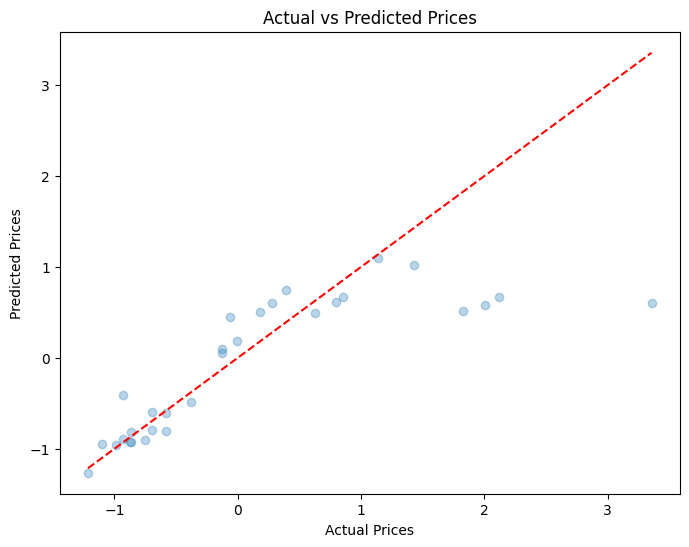

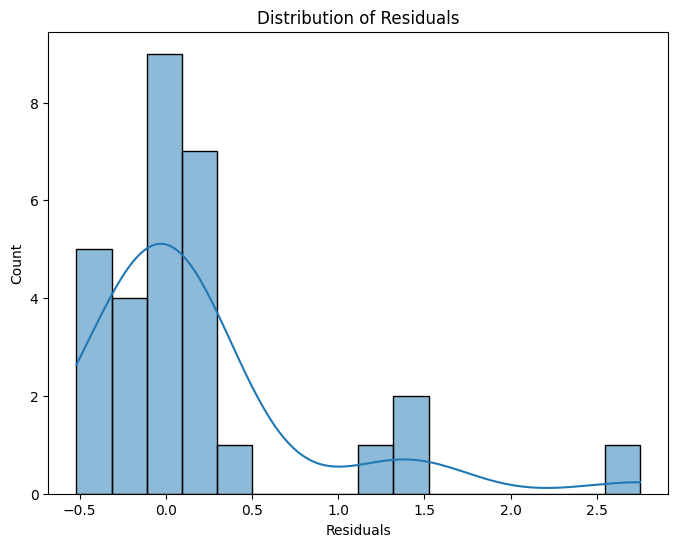

In [11]:

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
print(f'XGBoost MAPE: {mape:.2f}%')

# Scatter plot of predicted vs actual prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

# Distribution of residuals
residuals = y_test - y_pred_xgb
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()